In [2]:
from utils.getter import *
import torch.utils.data as data
import torch
from tqdm import tqdm
import torch.nn as nn

C:\Users\Kay Kieran\.conda\envs\main\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kay Kieran\.conda\envs\main\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Kay Kieran\.conda\envs\main\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
[nltk_data] Downloading package stopwords to C:\Users\Kay
[nltk_data]     Kieran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
transforms = Compose([
    Resize((300,300)),
    ToTensor(),
    Normalize(),
])

In [4]:
data_path = "datasets/datasets/Garbage Classification"
voc_path = "datasets/datasets/VOC/images"
voc_anno = {
    "train": "datasets/datasets/VOC/annotations/pascal_train2012.json",
    "val": "datasets/datasets/VOC/annotations/pascal_val2012.json"}

#trainset = ImageClassificationDataset(data_path+ "/train", transforms= transforms, shuffle=True)
#valset = ImageClassificationDataset(data_path+ "/val", transforms= transforms, shuffle = True)

trainset = ObjectDetectionDataset(img_dir=voc_path, ann_path = voc_anno['train'],transforms= transforms)
valset = ObjectDetectionDataset(img_dir=voc_path, ann_path = voc_anno['val'],transforms= transforms)
NUM_CLASSES = len(trainset.classes)
print(trainset)
print(valset)

Custom Dataset for Object Detection
-------------------------------
Number of samples: 5717
Number of classes: 20

Custom Dataset for Object Detection
-------------------------------
Number of samples: 5823
Number of classes: 20



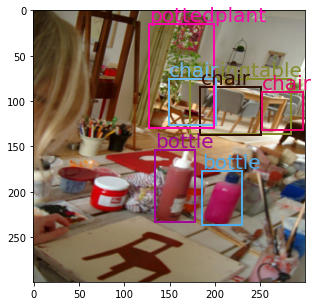

In [5]:
trainset.visualize_item(figsize=(5,5))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [7]:
from models.retinanet.retina_collator import *
my_collator = trainset.collate_fn#RetinaNetCollator()

In [8]:
# Dataloader
BATCH_SIZE = 4
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn = my_collator, shuffle=True)
valloader = data.DataLoader(valset, batch_size=BATCH_SIZE,collate_fn = my_collator, shuffle=False)

In [9]:
"""from models.retinanet.loss import FocalLoss
from models.retinanet.model import RetinaNet
criterion = FocalLoss(num_classes = NUM_CLASSES, device = device)
model = RetinaNet(num_classes = NUM_CLASSES).to(device)"""
from models.ssd.model import SSD300, MultiBoxLoss
model = SSD300(n_classes = NUM_CLASSES).to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
print(model)


Loaded base model.

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512,

In [10]:
for idx, batch in enumerate(trainloader):
    optimizer.zero_grad()
    imgs = batch['imgs'].to(device)
    boxes = [x.to(device) for x in batch['boxes']]
    labels = [x.to(device) for x in batch['labels']]
    
    
    loc_preds, cls_preds = model(imgs)
    loss = criterion(loc_preds,boxes, cls_preds,labels)
  
    #loss = sum([k for k in losses.values()])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if idx % 10 == 0:
        print('[{}/{}] | Loss: {} '.format(idx, len(trainloader), loss.item()))
        #print('[{}/{}] | C: {} | B: {} '.format(idx, len(trainloader), losses['C'].item(), losses['B'].item()))

[0/1430] | Loss: 1749.22900390625 
[10/1430] | Loss: 2194.65380859375 
[20/1430] | Loss: 1249.700439453125 
[30/1430] | Loss: 1253.1087646484375 
[40/1430] | Loss: 1172.6492919921875 
[50/1430] | Loss: 727.9773559570312 
[60/1430] | Loss: 574.2587890625 
[70/1430] | Loss: 795.596435546875 
[80/1430] | Loss: 883.09130859375 
[90/1430] | Loss: 752.397705078125 
[100/1430] | Loss: 1026.666259765625 
[110/1430] | Loss: 836.7576293945312 
[120/1430] | Loss: 419.8430480957031 
[130/1430] | Loss: 941.6522827148438 
[140/1430] | Loss: 1148.8751220703125 
[150/1430] | Loss: 1262.6463623046875 
[160/1430] | Loss: 482.0136413574219 
[170/1430] | Loss: inf 
[180/1430] | Loss: 1168.3035888671875 
[190/1430] | Loss: 473.7915344238281 
[200/1430] | Loss: 618.780517578125 
[210/1430] | Loss: 760.0830078125 
[220/1430] | Loss: 591.3820190429688 
[230/1430] | Loss: 526.4344482421875 
[240/1430] | Loss: 1314.7913818359375 
[250/1430] | Loss: 1039.521728515625 
[260/1430] | Loss: 648.5676879882812 
[270/1

In [12]:
for idx, batch in enumerate(trainloader):
    with torch.no_grad():
        imgs = batch['imgs'].to(device)
        boxes = [x.to(device) for x in batch['boxes']]
        labels = [x.to(device) for x in batch['labels']]
        loc_preds, cls_preds = model(imgs)
        det_boxes, det_labels, det_scores = model.detect_objects(
            loc_preds,
            cls_preds,
            min_score=0.01,
            max_overlap=0.45,
            top_k=200)
    break

D:\GITHUB\Pytorch-Custom-Template\models\ssd\model.py:495: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  condition = torch.tensor(condition, dtype=torch.uint8).to(device)
D:\GITHUB\Pytorch-Custom-Template\models\ssd\model.py:504: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:20.)
  image_boxes.append(class_decoded_locs[1 - suppress])
D:\GITHUB\Pytorch-Custom-Template\models\ssd\model.py:506: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:20.)
  image_scores.append(class_scores[1 - suppress])


In [15]:
print(det_scores)

[tensor([1.0000], device='cuda:0'), tensor([1.0000], device='cuda:0'), tensor([1.0000], device='cuda:0'), tensor([1.0000], device='cuda:0')]


In [1]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
metrics = [AccuracyMetric(decimals=3)]

NameError: name 'nn' is not defined

In [ ]:
NUM_CLASSES = len(trainset.classes)
model = ResNet34(NUM_CLASSES,
                 lr = 1e-4,
                 criterion= criterion, 
                 optimizer= optimizer,
                 metrics=  metrics,
                 device = device)
#load_checkpoint(model, "weights/ResNet34-12.pth")

In [ ]:
cp = Checkpoint(save_per_epoch=1)
trainer = Trainer(model,
                 trainloader, 
                 valloader,
                 checkpoint = cp, 
                 evaluate_per_epoch = 1)

trainer.fit(num_epochs=5)

In [ ]:
preds = trainer.inference_batch(valloader)
print(preds)

In [ ]:
idx = 35
print(valset.classes[preds[idx]])
valset.visualize_item(idx, figsize = (8,8))